# Dfs2

[DFS - Reference manual](https://docs.mikepoweredbydhi.com/core_libraries/dfs/dfs-file-system/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Reading data

In [2]:
from mikeio import Dfs2

dfs = Dfs2("data/gebco_sound.dfs2")

dfs

<mikeio.Dfs2>
dx: 0.00417
dy: 0.00417
Items:
  0:  Elevation <Total Water Depth> (meter)
Time: time-invariant file (1 step)

In [3]:
ds = dfs.read()
ds

<mikeio.Dataset>
Dimensions: (1, 264, 216)
Time: 2020-05-15 11:04:52 - 2020-05-15 11:04:52
Items:
  0:  Elevation <Total Water Depth> (meter)

In [4]:
type(ds)

mikeio.dataset.Dataset

In [5]:
ds.shape

(1, 264, 216)

In [6]:
elevation = ds['Elevation']
type(elevation)

numpy.ndarray

In [7]:
elevation.shape

(1, 264, 216)

Text(0, 0.5, 'Row # (starting at the top)')

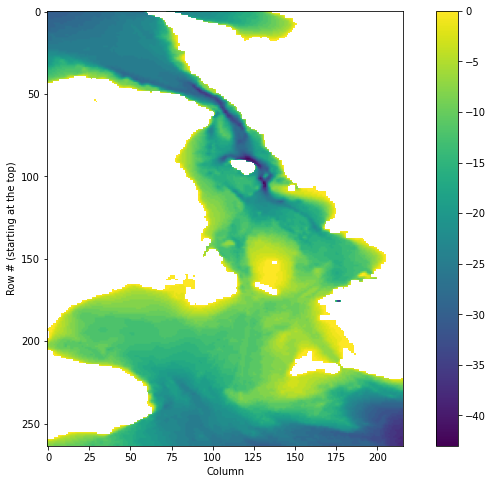

In [8]:
plt.subplots(figsize=(12,8))
plt.imshow(elevation[0])
plt.colorbar()
plt.xlabel("Column")
plt.ylabel("Row # (starting at the top)")

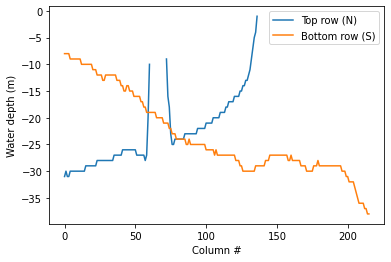

In [9]:
plt.plot(elevation[0,0,:], label="Top row (N)")
plt.plot(elevation[0,-1,:], label="Bottom row (S)")
plt.xlabel("Column #")
plt.ylabel("Water depth (m)")
plt.legend()

## Spatial axes

In [10]:
dfs.latitude, dfs.longitude

(55.20208333333332, 12.20208333333332)

In [11]:
dfs.dy, dfs.dx

(0.004166666883975267, 0.004166666883975267)

In [12]:
ny = elevation.shape[1]
nx = elevation.shape[2]
ny, nx

(264, 216)

In [13]:
lats = [dfs.latitude + dfs.dy*i  for i in range(ny)]
lons = [dfs.longitude + dfs.dx*i  for i in range(nx)]

In [14]:
lats[0], lats[-1]

(55.20208333333332, 56.297916723818815)

In [15]:
lons[0], lons[-1]

(12.20208333333332, 13.097916713388003)

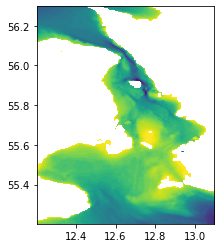

In [16]:
plt.imshow(elevation[0], extent=(lons[0], lons[-1], lats[0], lats[-1]))

## Extract data at location

In [17]:
stn = 12.74792, 55.865
k,j = dfs.find_nearest_elements(lon=stn[0],lat=stn[1])
print(k,j)

104 131


Text(0.5, 1.0, 'Indexed by row/column')

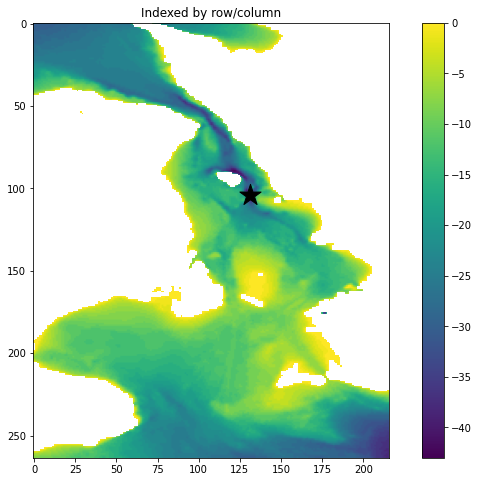

In [18]:
plt.subplots(figsize=(12,8))
plt.imshow(elevation[0])
plt.colorbar()
plt.scatter(j,k,marker='*',s=500,c='black')
plt.title("Indexed by row/column")

Text(12.3, 55.8, 'Denmark')

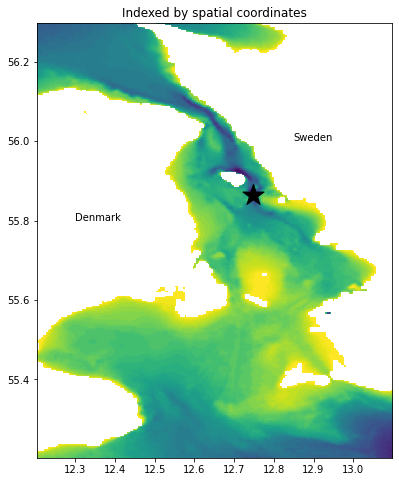

In [19]:
plt.subplots(figsize=(12,8))
plt.imshow(elevation[0], extent=(lons[0], lons[-1], lats[0], lats[-1]))
plt.scatter(stn[0],stn[1],marker='*',s=500,c='black')
plt.title("Indexed by spatial coordinates")
plt.text(12.85, 56.0, "Sweden")
plt.text(12.3, 55.8, "Denmark")

In [20]:
import numpy as np

# Find minimum value
idx_1d = np.nanargmin(elevation)
idx_1d

22595

In [21]:
idx = np.unravel_index(idx_1d, elevation.shape)
idx

(0, 104, 131)

In [22]:
elevation[idx]

-43.0

## Slicing

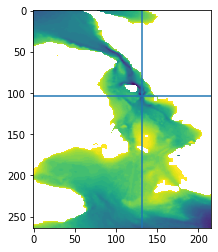

In [23]:
plt.imshow(elevation[0])
plt.axvline(j)
plt.axhline(k)

Text(0.5, 1.0, 'North-South')

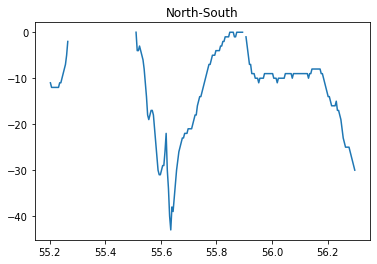

In [24]:
plt.plot(lats, elevation[0,:,j])
plt.title("North-South")

Text(0.5, 1.0, 'West-East')

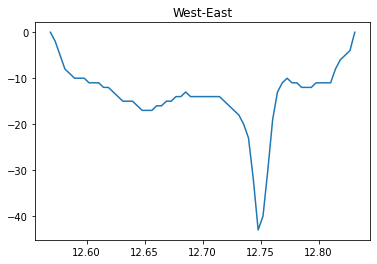

In [25]:
plt.plot(lons, elevation[0,k,:])
plt.title("West-East")

## Writing data

### Geographical coordinates

In [26]:
data_i = np.arange(24).reshape(2,4,3)
data_i.shape

(2, 4, 3)

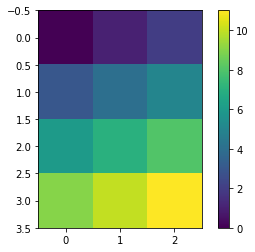

In [27]:
plt.imshow(data_i[0]) # first timestep
plt.colorbar()

In [28]:
import pandas as pd

from mikeio import Dataset
from mikeio.eum import EUMType, ItemInfo

nt = data_i.shape[0]

ds = Dataset(data=[data_i],
             time=pd.date_range("2020",periods=nt,freq='D'),
             items=[ItemInfo("Example",EUMType.Elevation)])
ds

<mikeio.Dataset>
Dimensions: (2, 4, 3)
Time: 2020-01-01 00:00:00 - 2020-01-02 00:00:00
Items:
  0:  Example <Elevation> (meter)

In [29]:
dfs = Dfs2()
dfs.write("example_geo.dfs2",data=ds, coordinate=["LONG/LAT", 55.0, 12.0, 0.0], dx=1.0, dy=1.0)


Screenshot from MIKE Zero (viridis palette).

:::{note}
Note the location of the origin.
:::


![](images/example_dfs2_geo.png)

### Projected coordinates


Projection string in WKT format. Use MIKE Zero for formatting. Some shorthands are available for UTM zones, e.g. UTM-32.

In [30]:
from mikecore.Projections import Cartography

proj = Cartography.CreateProjOrigin("UTM-32", east=337100.0, north=6122900.0, orientationProj=0.0)
proj.ProjectionString

'PROJCS["UTM-32",GEOGCS["Unused",DATUM["UTM Projections",SPHEROID["WGS 1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",0],PARAMETER["Central_Meridian",9],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'

In [31]:
proj.LonOrigin, proj.LatOrigin, proj.Orientation

(6.438741601179531, 55.22570782640155, -2.104289814530738)

In [35]:
dfs = Dfs2()
dfs.write("example_proj.dfs2",
          data=ds, 
          coordinate=[proj.ProjectionString, proj.LonOrigin, proj.LatOrigin, proj.Orientation],
          dx=10000, dy=10000)


Screenshot from MIKE Zero using a projected coordinate system.

![](images/example_dfs2_proj.png)